# SWMM with Python

Python is becoming the standard for state of the art data analysis language. If you are interested in applying the latest data science anlysis to your swmm model, let's get started.


# Required Software

## Python

For beginners, I would recommend using [anaconda](https://www.anaconda.com/products/individual) to simpify the installation of python. I am using the 64bit python 3.7 for this notebook.


## Jupyter Lab

Then you can setup [Jupyter Lab](https://dzone.com/articles/getting-started-with-jupyterlab), open the Anaconda prompt

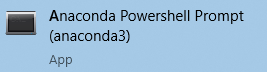

Then run the following commands

```powershell
conda install -c conda-forge jupyterlab
jupyter lab
```

## PySwmm

You can install [pyswmm](https://github.com/OpenWaterAnalytics/pyswmm) using the anaconda prompt
```
pip install pyswmm
```

## swmm-python

[swmm-python](https://github.com/OpenWaterAnalytics/swmm-python) is still in pre-release, the installation is a little more tricky.

This is the [release](https://github.com/OpenWaterAnalytics/swmm-python/releases/tag/v0.3.0-dev1) I used. We need to download the .whl file for your version of python.

I installed [swmm.output for 64bit python 3.7](https://github.com/OpenWaterAnalytics/swmm-python/releases/download/v0.3.0-dev1/swmm.output-0.4.0.dev1-cp37-cp37m-win_amd64.whl)

1. download the \*.whl file to your computer
1. start anaconda prompt and run the command below
```bash
pip install "c:...path to the whl file"
```



# Get the data

I am going to use the pyswmm [example input file](https://raw.githubusercontent.com/OpenWaterAnalytics/pyswmm/master/pyswmm/tests/data/model_full_features.inp). Download it and save it to my hard drive.



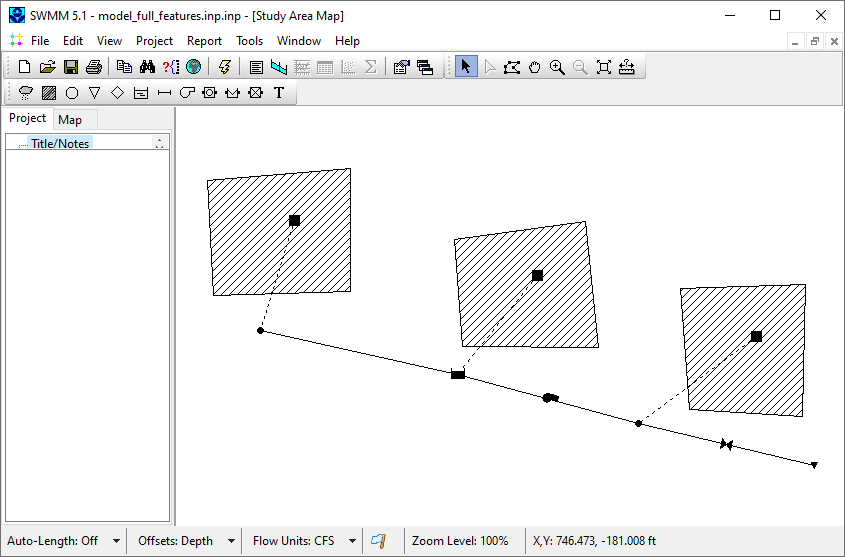

# Run a swmm model using pySWMM

pySWMM is very powerful if you are interested in real-time applications. You can run the model one time step a time and then make changes to the controls.

In the code sample below, I simply collect the subcachement results into a time series and then plot it.

In [18]:
from pyswmm import Simulation, Subcatchments
import pandas as pd
import matplotlib.pyplot as plt


with Simulation(r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\swmm_and_python\data\model_full_features.inp") as sim:
    S1 = Subcatchments(sim)["S1"]
    S2 = Subcatchments(sim)["S2"]
    idx = []
    s1_values = []
    s2_values = []
    
    for step in sim:
        idx.append(sim.current_time)
        s1_values.append(S1.runoff)
        s2_values.append(S2.runoff)
    df = pd.DataFrame({'S1 Runoff': s1_values, 'S2 Runoff': s2_values}, index=idx)
    

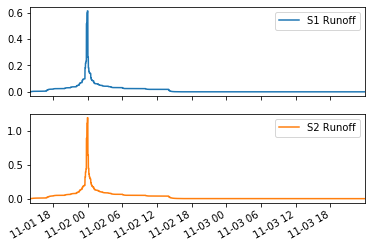

          S1 Runoff      S2 Runoff
count  2.088000e+05  208800.000000
mean   1.676060e-02       0.033509
std    4.602423e-02       0.089107
min    5.242432e-07       0.000003
25%    2.041189e-06       0.000011
50%    5.029121e-05       0.000253
75%    2.420089e-02       0.048402
max    6.128817e-01       1.188562


In [34]:
# let's compare s1 and s2 results
df.plot(subplots=True)
plt.show()
print(df.describe())

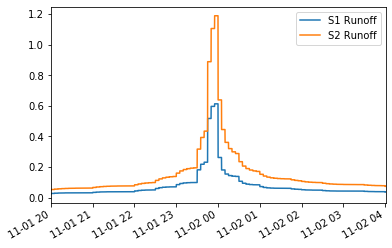

In [35]:
# let's zoom in and compare the peak
df['11/1/2015 20:00':'11/02/2015 4:00'].plot(subplots=False)
plt.show()

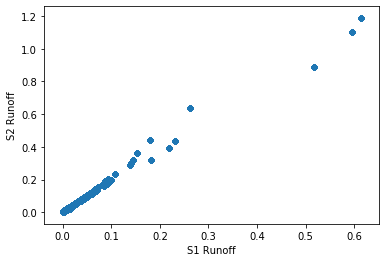

In [22]:
# let's see if they are correlated
df.plot.scatter(x='S1 Runoff', y='S2 Runoff')
plt.show()

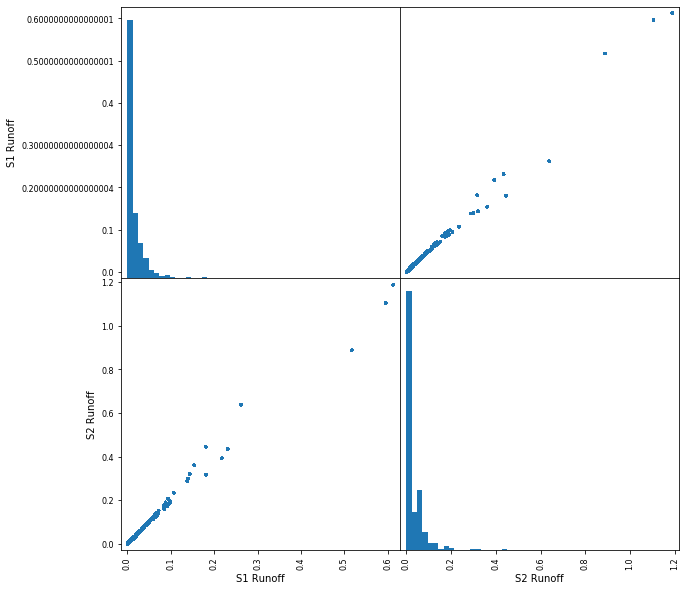

In [39]:
# compare the correlation between the results
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(10, 10), hist_kwds={'bins':50})
plt.show()

# Use swmm.output to read the results

If we are only interested in reading the results, we can get the result directly from the output file.

The swmm.output lib is built for that purpose.

In [41]:
from pyswmm import Simulation, Subcatchments
import pandas as pd
import matplotlib.pyplot as plt

# run the model to get the *.out file
sim = Simulation(r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\swmm_and_python\data\model_full_features.inp")
sim.execute()


... SWMM Version 5.3.0.dev0
... Run Complete

In [132]:
from swmm.output import output as smo
import datetime
def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1

In [131]:
# extract the results from *.out file
handle = smo.init()
smo.open(handle, r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\swmm_and_python\data\model_full_features.out")

# swmm out file report time using its only integer format, it needs to be converted to datetime
report_start_date_time = smo.getstartdate(handle)
start_dt = swmm_dt(report_start_date_time)

# to build the timestamps, we'll need the number of reported steps, and the step length in seconds
num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

# build the date range
timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


# Just want to confirm the subcatchments index 
print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 0))
print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 1))

# get the time sereis from the out file
s1_values = smo.getsubcatchseries(handle, 0, smo.SubcatchAttribute.RUNOFF_RATE, 0, num_steps)
s2_values = smo.getsubcatchseries(handle, 1, smo.SubcatchAttribute.RUNOFF_RATE, 0, num_steps)

S1
S2


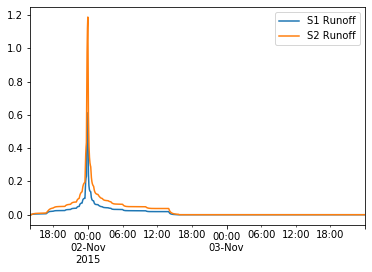

,S1 Runoff,S2 Runoff
count,3480.000000,3480.000000
mean,0.016740,0.033448
std,0.045462,0.088315
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.024201,0.048402
max,0.612882,1.188562


In [129]:
# show the *.out results
df2 = pd.DataFrame({'S1 Runoff': s1_values, 'S2 Runoff': s2_values}, index=timestep)
df2.plot()
plt.show()
df2.describe()

C:\Users\Mel.Meng\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


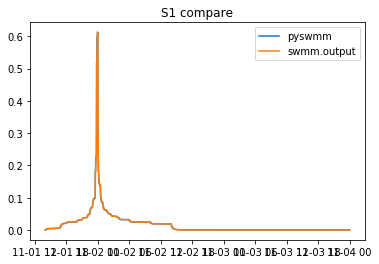

In [130]:
# compare the report results and actual timestep results
plt.plot(df.index, df['S1 Runoff'], label='pyswmm')
plt.plot(df2.index, df2['S1 Runoff'], label='swmm.output')
plt.legend()
plt.title('S1 compare')
plt.show()

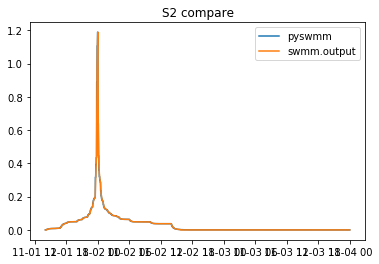

In [125]:
plt.plot(df.index, df['S2 Runoff'], label='pyswmm')
plt.plot(df2.index, df2['S2 Runoff'], label='swmm.output')
plt.legend()
plt.title('S2 compare')
plt.show()

# What's next

Now you've learned the basics of running a swmm model and reading the results. Next there are a few things I would like to do,

- sensitivity analysis: I would like to write scripts to change model parameters and then analyze its impact on the results. Without scripts, this can take a very long time.
- optimization: using genetic algrithm to calibrate rtk parameter will be a fun project, but this migh